# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных:

## Признаки:
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

## Целевой признак:
- **Price** — цена (евро)

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

# План работы:

1. Загрузка и подготовка данных
2. Обучение разных моделях на разных гиперпараметрах
3. Анализ скорости и качества работы разных моделей. Оценка качества будет производиться с помощью метрики RMSE.

# Загрузка библиотек:

In [1]:
import warnings; warnings.filterwarnings("ignore", category=Warning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as ltb
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# 1. Загрузка и подготовка данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


С типами данных всё в порядке, однако присутствуют пропуски в различных столбцах, взглянем на них подробнее с помощью гистограммы.

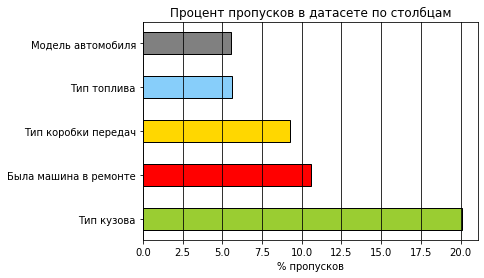

In [4]:
percentage_of_nans = df.isna().mean().round(4) * 100
percentage_of_nans = percentage_of_nans[percentage_of_nans > 0]
percentage_of_nans.index = (['Была машина в ремонте', 'Тип топлива', 'Модель автомобиля', 'Тип коробки передач', 'Тип кузова'])
percentage_of_nans = percentage_of_nans.sort_values(ascending = False)
colors = ['yellowgreen','red','gold','lightskyblue','grey','lightcoral','blue','pink', 'darkgreen','yellow']

x = percentage_of_nans.keys()
y = percentage_of_nans.values

fig, ax = plt.subplots()

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.grid(axis = 'x', color = 'black')
plt.barh(x, y, color = colors, edgecolor = 'black', height = 0.5)
plt.xlabel('% пропусков')
plt.title('Процент пропусков в датасете по столбцам')
plt.show()

Видим что наибольшее количество пропусков находится в столбце "Тип кузова", также достаточно много (> 7.5%) пропусков в столбцах "Тип коробки передачи" и "Была ли машина в ремонте". В дальнейшем необходимо будет подробнее рассмотреть данные столбцы, при необходимости построить графики распределений, и принять решение - как следует поступить с пропусками в этих столбцах. 

Перед этим взглянем на коррелограмму по столбцам с числовыми значениями в нашем датасете.

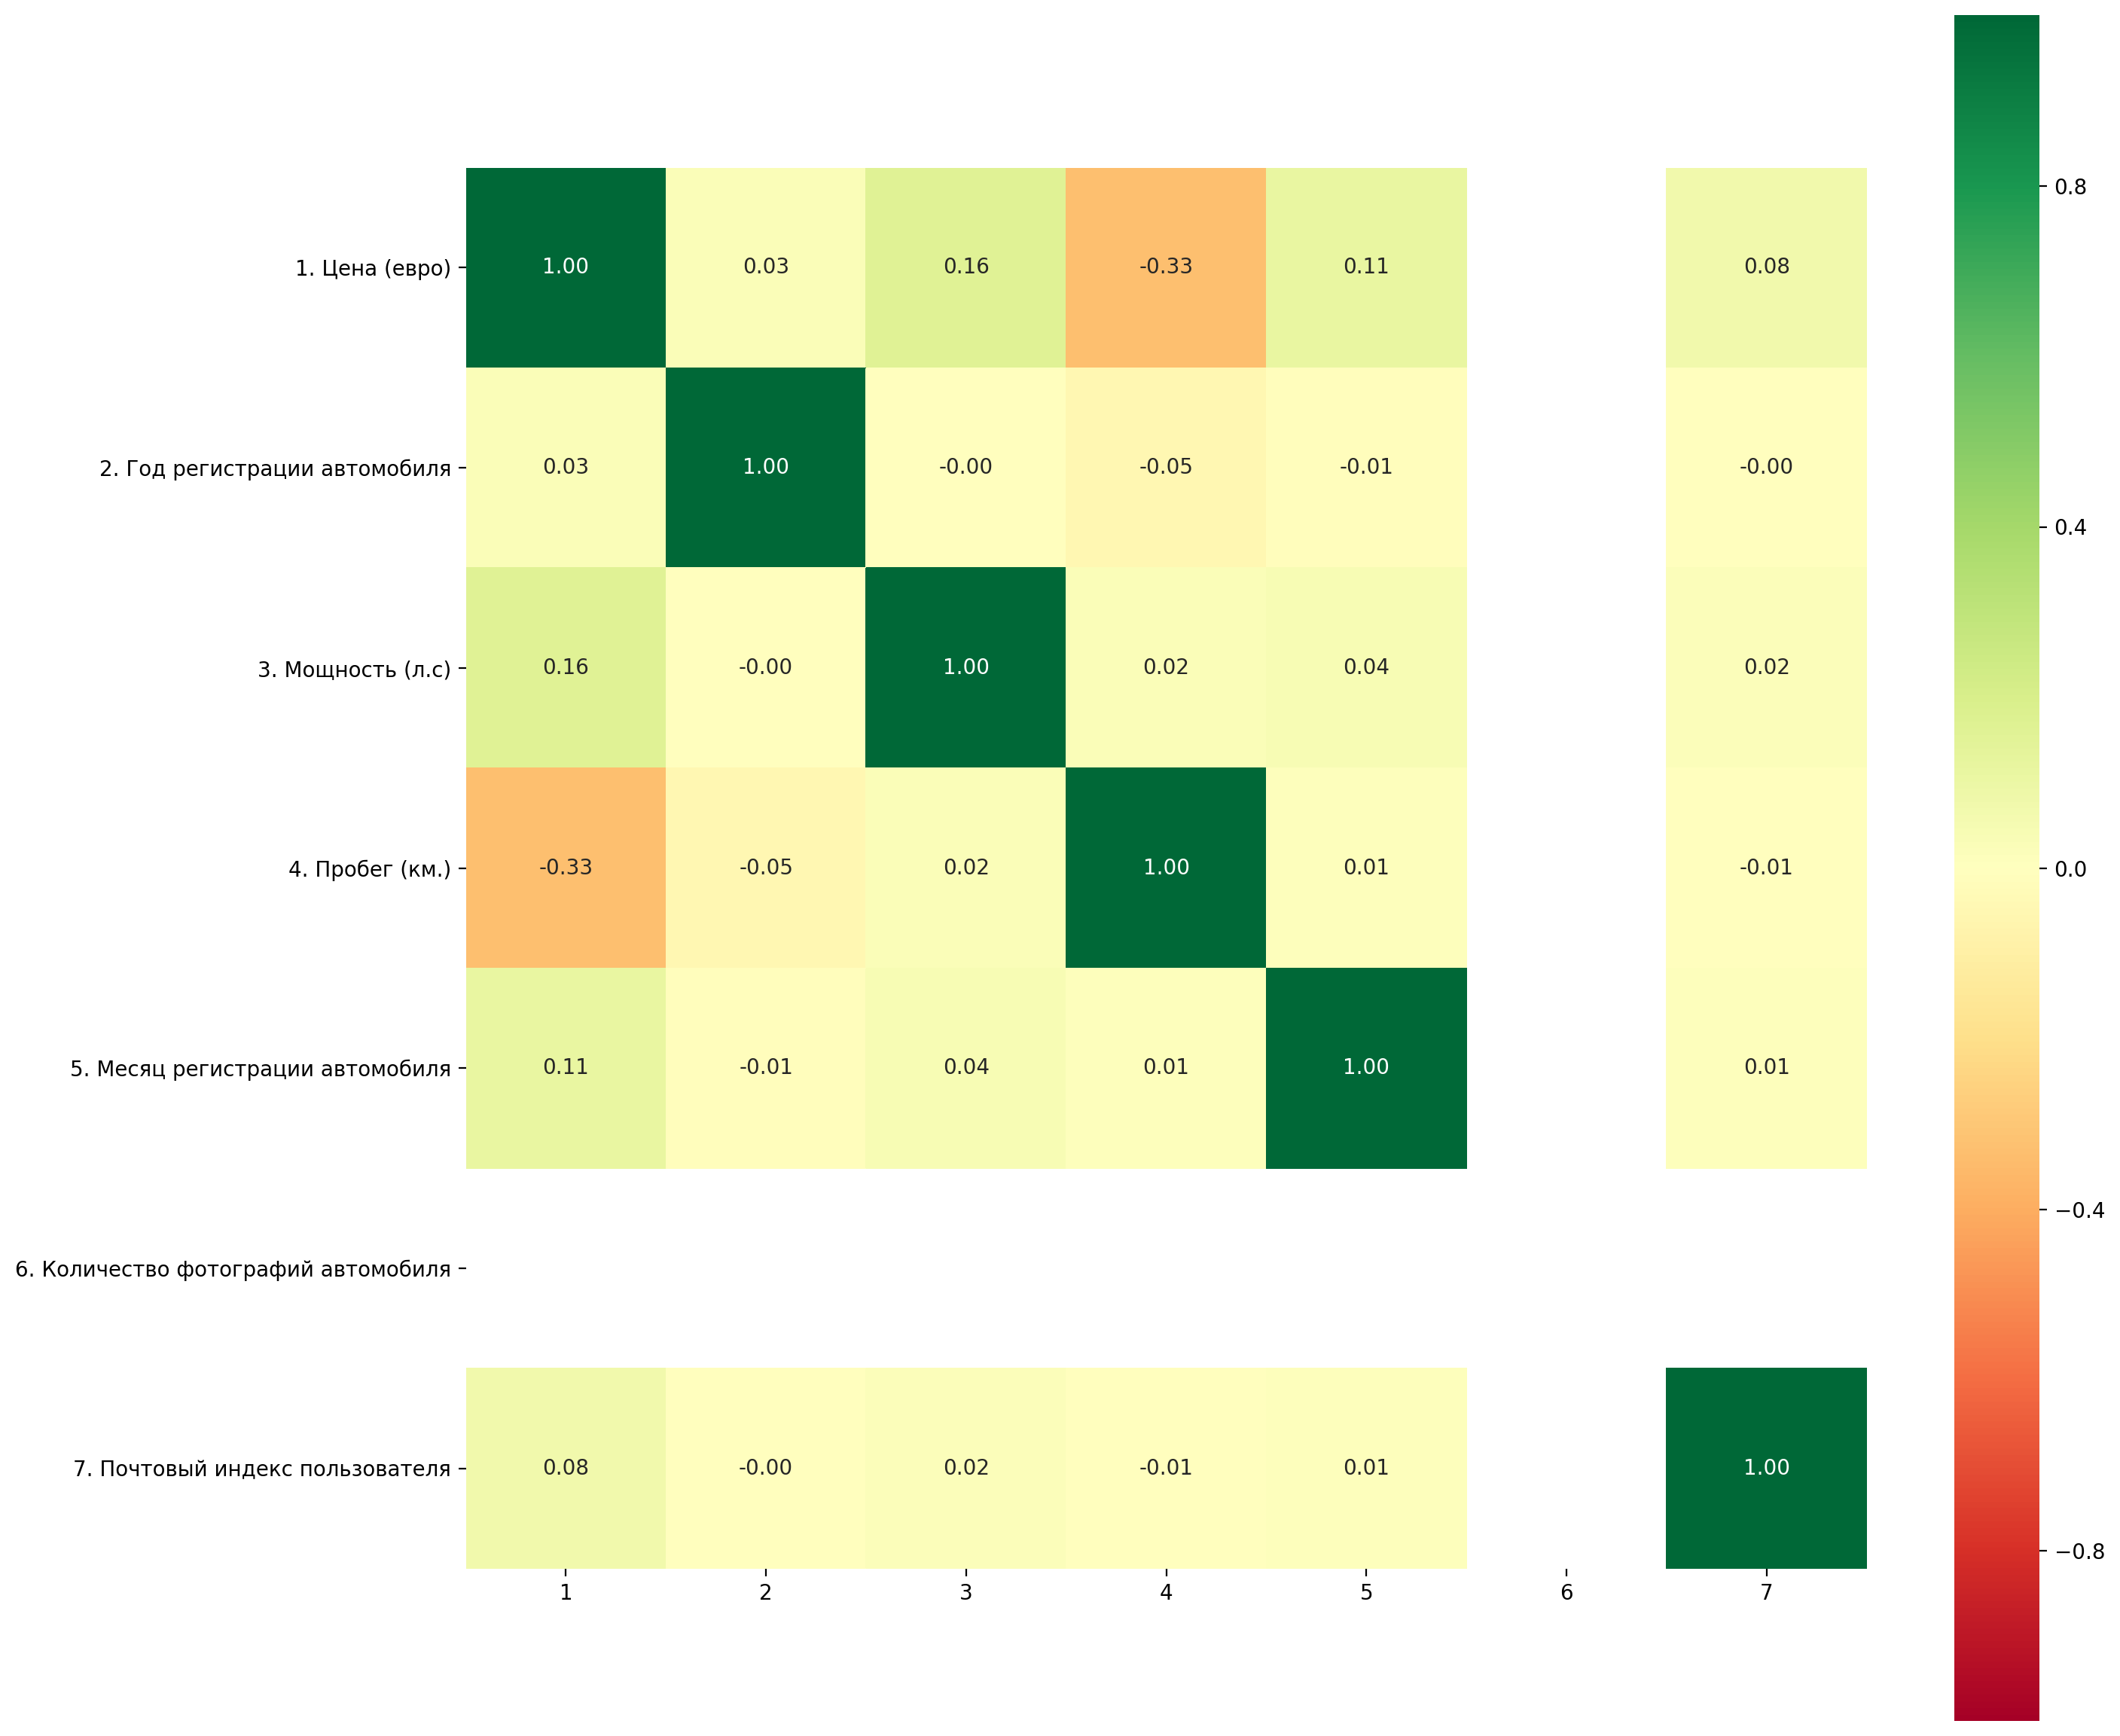

In [5]:
correl_columns_y = ['1. Цена (евро)', '2. Год регистрации автомобиля', '3. Мощность (л.с)', '4. Пробег (км.)', 
                    '5. Месяц регистрации автомобиля', '6. Количество фотографий автомобиля', '7. Почтовый индекс пользователя']

correl_columns_x = list(range(1, 8))
plt.figure(figsize=(15,15), dpi=200)

sns.heatmap(df.corr(), xticklabels = correl_columns_x, yticklabels=correl_columns_y, 
            cmap='RdYlGn', center=0, annot=True, fmt='.2f', vmin=-1, vmax=1, square = True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Исходя из коррелограммы наблюдаем что наибольшее влияние на цену оказывает мощность, пробег, год и месяц регистрации автомобиля. Количество фотографий у автомобиля по какой-то причине не оказывает влияние на показатели цены автомобиля. Аномалия с почтовым индексом скорее всего объясняется тем что почтовый код указан в качестве чистого числового значения (по своей сути он нам не нужен и не должен оказывать влияние на итоговую цену автомобиля, соответственно мы избавимся от этого столбца в будущем).

Теперь взглянем в чем причина нулевого влияния количества фотографий автомобиля на конечную цену:

In [6]:
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Причина обнаружена - все значения в этом столбце всегда равны нулю, соответственно он нам не понадобится. Также сразу определим какие столбцы нам понадобятся для обучения и проверки моделей:

- **VehicleType** - Тип машины обязательно необходим, чем больше возможносей у машины, тем выше цена.
- **GearBox** - Тип коробки передач также определяет стоимость автомобиля - если это автомат, то стоимость машины возрастёт.
- **Power** - По коррелограмме определили, что мощность автомобиля напрямую влияет на цену. 
- **Kilometr**- Также по коррелограмме определили, что чем меньше пробег у автомобиля - тем выше цена.
- **FuelType** - Тип топлива тоже имеет косвенное влияние на стоимость автомобиля, так как оно определяет конструкцию двигателя
- **Brand** - Бренд автомобиля напрямую влияет на стоимость автомобиля, так как доверие потребителей к разным брендам сильно варьируется
- **NotRepaired** - Случались ли с автомобилем какие-либо технические неполадки, или же попадала ли она в ДТП - напрямую влияет на стоимость автомобиля.
- **RegistrationYear** - Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.
- **Model** - В совокупности с типом машины и брендом также может влиять на популярность у покупателей.

Теперь определим от каких столбцов необходимо избавиться:

- **DateCrawled** - дата скачивания анкеты из базы не имеет для нас практической необходимости
- **RegistrationMonth** - особой необходимости содержать этот признак не имеет нужды так как у нас есть год регистрации
- **DateCreated** - аналогично с датой скачивания анкеты из базы
- **PostalCode** - лишняя информация не имеющая практической ценности
- **LastSeen** - аналогично с почтовым индексом.

От столбцов избавимся после полной обработки пропусков в данных. Теперь же взглянем на общее количество пропусков, нулевых значений и дубликатов.

Нашли четыре дубликата, взглянем на них подробнее.

In [7]:
print('Количество пропусков -', df.isna().sum().sum())
print('Количество нулевых значений -', df.isnull().sum().sum())
print('Количество дубликатов -', df.duplicated().sum())

Количество пропусков - 181077
Количество нулевых значений - 181077
Количество дубликатов - 4


In [8]:
df[df.duplicated(keep = False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Выглядят как абсолютные дубликаты - избавляемся от них

In [9]:
df = df.drop_duplicates()

Теперь взглянем подробнее на столбец **Gearbox**

In [10]:
print(df['Gearbox'].value_counts(normalize = True))
print('Количество пропусков в столбеце "Gearbox" - ', len(df[df['Gearbox'].isna() == True]))

manual    0.801863
auto      0.198137
Name: Gearbox, dtype: float64
Количество пропусков в столбеце "Gearbox" -  19833


Видим что аномальных значений в столбец нет, однако присутствует почти 20 тыс. пропусков. Обработаем их равномерно распределив пропуски по уже существующему распределению чтобы исключить возможность перекоса данных. 

In [11]:
replace_list = [round(df['Gearbox'].value_counts(normalize = True)[0] * len(df[df['Gearbox'].isna() == True])), 
                round(df['Gearbox'].value_counts(normalize = True)[1] * len(df[df['Gearbox'].isna() == True]))]

df['Gearbox'] = df['Gearbox'].fillna(value = 'manual', limit = replace_list[0])
df['Gearbox'] = df['Gearbox'].fillna(value = 'auto', limit = replace_list[1])

print(df['Gearbox'].value_counts(normalize = True))
print('Количество пропусков в столбце "Gearbox" =', len(df[df['Gearbox'].isna() == True]))

manual    0.801862
auto      0.198138
Name: Gearbox, dtype: float64
Количество пропусков в столбце "Gearbox" = 0


Переходим к столбцу **FuelType**. Взглянем на распределение значений.

In [12]:
print(df['FuelType'].value_counts(normalize = True))
print('Количество пропусков в столбце "FuelType"', len(df[df['FuelType'].isna() == True]))

petrol      0.672999
gasoline    0.307086
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: FuelType, dtype: float64
Количество пропусков в столбце "FuelType" 32895


Аномалии отсутствуют, однако опять же присутствует большое количество пропусков. Обработаем их аналогичным образом как со столбцом **Gearbox**

In [13]:
replace_list = [round(df['FuelType'].value_counts(normalize = True)[0] * len(df[df['FuelType'].isna() == True])), 
                round(df['FuelType'].value_counts(normalize = True)[1] * len(df[df['FuelType'].isna() == True])),
                round(df['FuelType'].value_counts(normalize = True)[2] * len(df[df['FuelType'].isna() == True]))]

df['FuelType'] = df['FuelType'].fillna(value = 'gasoline', limit = replace_list[1])
df['FuelType'] = df['FuelType'].fillna(value = 'lpg', limit = replace_list[2])
df['FuelType'] = df['FuelType'].fillna(value = 'petrol')

print(df['FuelType'].value_counts(normalize = True))
print('Количество пропусков в столбце "FuelType" =', len(df[df['FuelType'].isna() == True]))

petrol      0.673314
gasoline    0.307087
lpg         0.016517
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: FuelType, dtype: float64
Количество пропусков в столбце "FuelType" = 0


Пропуски в данном столбце успешно обработаны, теперь переходим к столбцу **Brand**.

In [14]:
print(df['Brand'].value_counts())
print('Количество пропусков в столбце "Brand" -', len(df[df['Brand'].isna() == True]))

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64
Количество про

Со значениями всё в порядке, пропуски отсутствуют. Переходим к столбцу **Price**.
В первую очередь взглянем на распределение значений в этом столбце

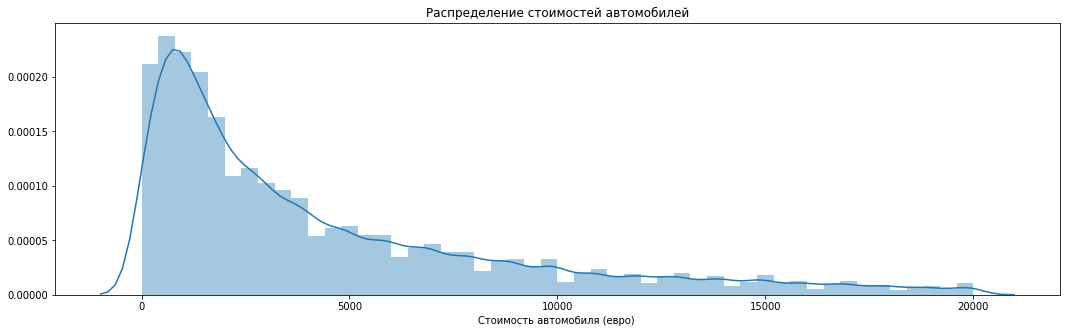

In [15]:
plt.figure(figsize=(18,5))
ax = sns.distplot(df['Price'])
ax.set(xlabel='Стоимость автомобиля (евро) ', 
       title='Распределение стоимостей автомобилей')
plt.show()

Наблюдаем большое количество выборосов ровно на нулевой стоимости автомобиля, вполне возможно ресурс с которого производилась выгрузка анкет предоставляет возможность устанавливать "договорную цену" для пользователей которые хотят договариваться о цене с каждым покупателем индивидуально, поэтому при выгрузке такие значения проставились нулями. Или же возможен вариант обычной технической ошибки при выгрузке.
Для обучения и анализа моделей такие значения в датасете нам не нужны, соответственно избавимся от этих значений.

In [16]:
df = df.query('Price > 0')

Значения срезали, снова взглянем на распределение.

In [17]:
df['Price'].describe()

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Видим что ситуация не стала существенно лучше - минимальное значение равно 1. Для более получения более репрезентативных значений срежем значения по квантилям 5% и 95%.

In [18]:
df['Price'].quantile([0.05, 0.95])

0.05      350.0
0.95    14800.0
Name: Price, dtype: float64

In [19]:
df = df.query('350 <= Price <= 14900')

Значения срезали, для проверки еще раз взглянем на распределение стоимостей.

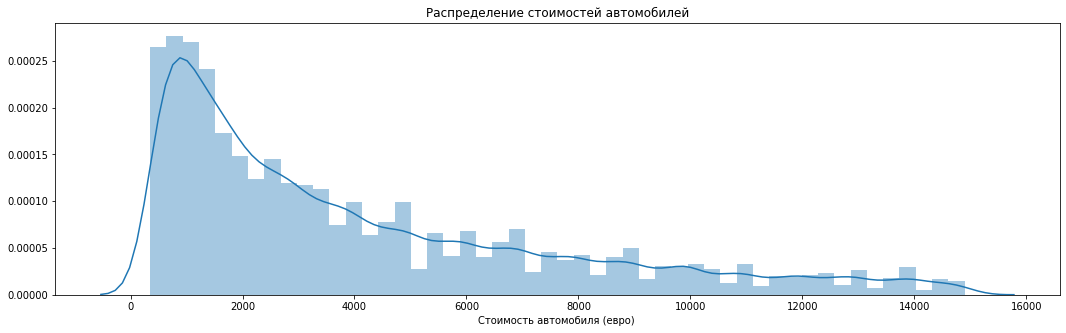

In [20]:
plt.figure(figsize=(18,5))
ax = sns.distplot(df['Price'])
ax.set(xlabel='Стоимость автомобиля (евро) ', 
       title='Распределение стоимостей автомобилей')
plt.show()

Столбец с ценой успешно обработан, теперь переходим к столбцу **RegistrationYear**. В первую очередь, аналогично, взглянем на распределение по годам.

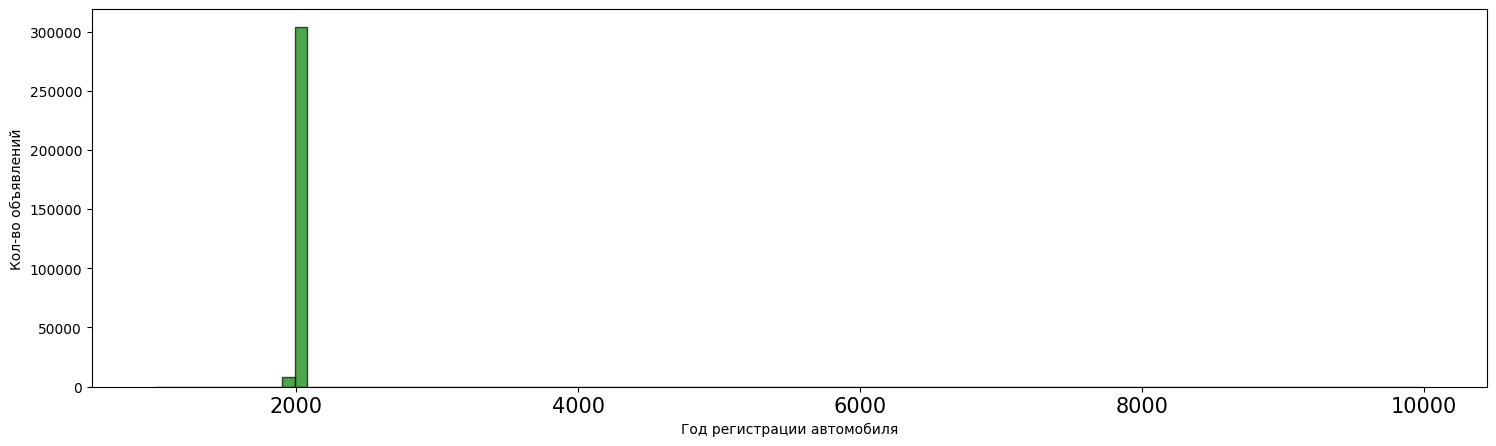

In [21]:
x = df['RegistrationYear']
plt.figure(figsize=(18, 5), dpi = 100)
plt.hist(x, bins=100, 
         range=(x.min(), x.max()), 
         color ='green',
         alpha = 0.7,
         edgecolor = 'black')
plt.ylabel('Кол-во объявлений')
plt.xlabel('Год регистрации автомобиля');
plt.yticks(fontsize=10)
plt.xticks(fontsize=15)
plt.show()

Видим что присутствуют выбросы в виде неадекватных годов свыше 2021 и меньше 1900. Сразу же срежем - верхнюю границу получим с помощью последней даты выгрузки анкеты из базы, за нижнюю границу возьмем 1970 год (более ранние года брать не имеет смысла, так как раритетные и ретро-автомобили будем считать за выбросы).

In [22]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

In [23]:
df = df.query('1970 < RegistrationYear < 2016')

Значения срезали, взглянем еще раз на распределение значений.

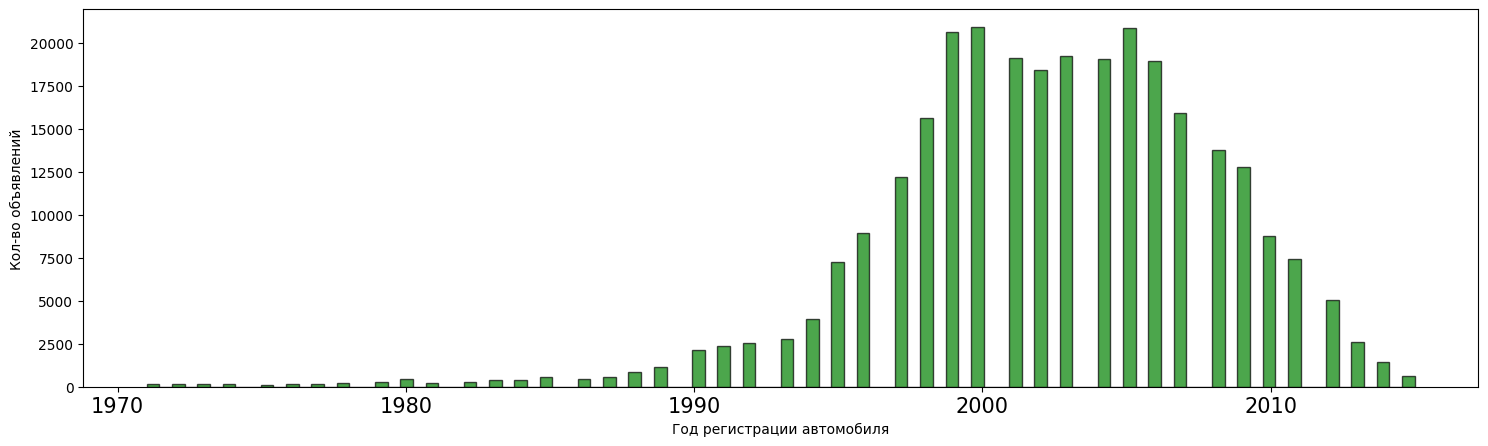

In [24]:
x = df['RegistrationYear']
plt.figure(figsize=(18, 5), dpi = 100)
plt.hist(x, bins=100, 
         range=(x.min(), x.max()), 
         color ='green',
         alpha = 0.7,
         edgecolor = 'black')
plt.ylabel('Кол-во объявлений')
plt.xlabel('Год регистрации автомобиля');
plt.yticks(fontsize=10)
plt.xticks(fontsize=15)
plt.show()

Столбец с годами регистрации автомобилей обработан, переходим к столбцу **NotRepaired**.

In [25]:
print(df['NotRepaired'].value_counts(normalize = True))
print('Количество пропусков в столбце "NotRepaired" -', len(df[df['NotRepaired'].isna() == True]))

no     0.888596
yes    0.111404
Name: NotRepaired, dtype: float64
Количество пропусков в столбце "NotRepaired" - 47977


Аномальных значений так же не наблюдается, однако есть пропуски. Их обработаем уже по привычной схеме - равномерно распределив уже по имеющемуся распределнию значений.

In [26]:
replace_list = [round(df['NotRepaired'].value_counts(normalize = True)[0] * len(df[df['NotRepaired'].isna() == True])), 
                round(df['NotRepaired'].value_counts(normalize = True)[1] * len(df[df['NotRepaired'].isna() == True]))]

df['NotRepaired'] = df['NotRepaired'].fillna(value = 'no', limit = replace_list[0])
df['NotRepaired'] = df['NotRepaired'].fillna(value = 'yes', limit = replace_list[1])

print(df['NotRepaired'].value_counts(normalize = True))
print('Количество пропусков в столбце "NotRepaired" =', len(df[df['NotRepaired'].isna() == True]))

no     0.888596
yes    0.111404
Name: NotRepaired, dtype: float64
Количество пропусков в столбце "NotRepaired" = 0


Столбец обработан - переходим к столбцу **Power**.

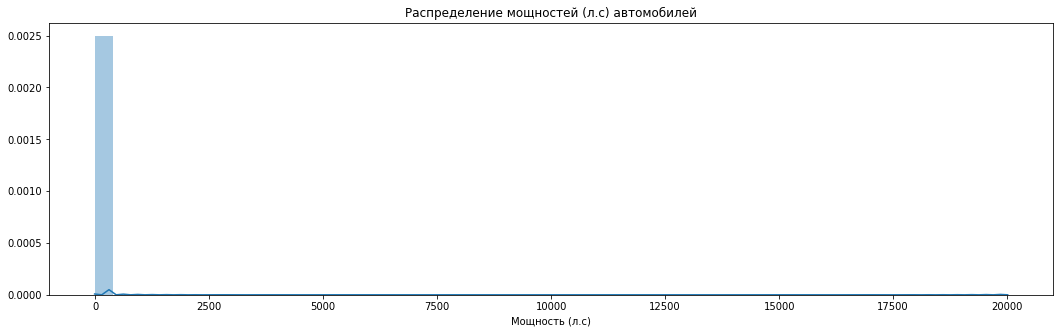

In [27]:
plt.figure(figsize=(18,5))
ax = sns.distplot(df['Power'])
ax.set(xlabel='Мощность (л.с)', 
       title='Распределение мощностей (л.с) автомобилей')
plt.show()

Видим что опять присутствуют выбросы - автомобили с мощностью свыше 1 тыс. лошадиных сил присутствовать практически не могут по объективным причинам. Соответственно, срежем значения по этой границе и снова взглянем на распределение.

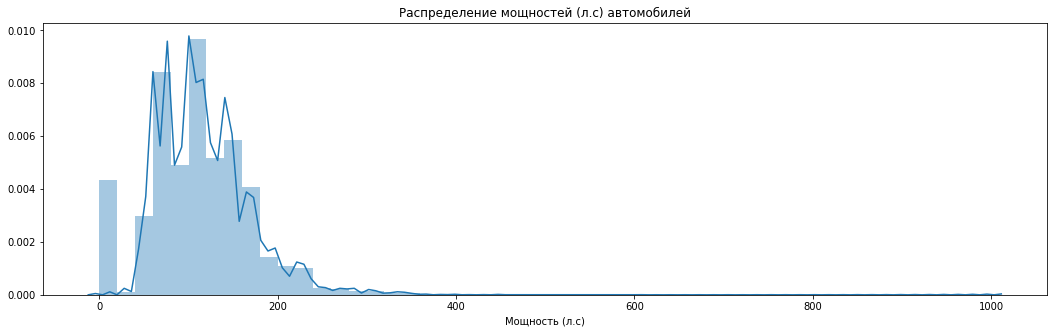

In [28]:
df = df.query('Power < 1000')

plt.figure(figsize=(18,5))
ax = sns.distplot(df['Power'])
ax.set(xlabel='Мощность (л.с)', 
       title='Распределение мощностей (л.с) автомобилей')
plt.show()

Значения стали чуть более репрезентативны, однако теперь присутствует большой хвост по значениям свыше 500 л.с. и выброс в виде очень низких мощностей автомобиля. Срежем значения по нижней границе в 30 л.с. и верхней границе в 500 л.с.

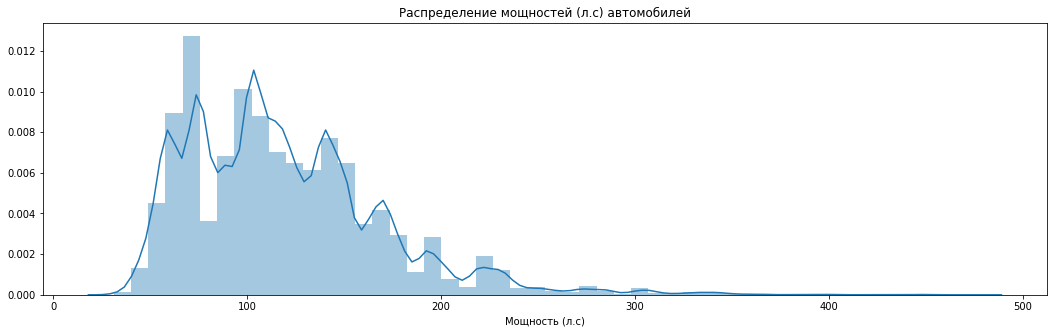

In [29]:
df = df.query('30 < Power < 500')

plt.figure(figsize=(18,5))
ax = sns.distplot(df['Power'])
ax.set(xlabel='Мощность (л.с)', 
       title='Распределение мощностей (л.с) автомобилей')
plt.show()

Столбец успешно обработан, переходим к столбцу **VehicleType**.

In [30]:
print(df['VehicleType'].value_counts())
print('Количество пропусков в столбце "VehicleType" -', len(df[df['VehicleType'].isna() == True]))

sedan          76516
small          64463
wagon          54838
bus            24511
convertible    16555
coupe          12427
suv             8776
other           2176
Name: VehicleType, dtype: int64
Количество пропусков в столбце "VehicleType" - 3753


Неизвестные нам значения в данном столбце отсутствуют, присутствуют пропуски в небольшом количестве - поэтому просто избавимся от них.

In [31]:
df = df.drop((df[df['VehicleType'].isna() == True]).index)
print('Количество пропусков в столбце "VehicleType" -', len(df[df['VehicleType'].isna() == True]))

Количество пропусков в столбце "VehicleType" - 0


Переходим к столбцу **Model**.

In [32]:
print(df['Model'].value_counts())
print('Количество пропусков в столбце "Model" -', len(df[df['Model'].isna() == True]))

golf                  21371
other                 17675
3er                   15773
polo                   9357
corsa                  8715
                      ...  
q3                        2
serie_3                   2
range_rover_evoque        2
serie_2                   2
rangerover                1
Name: Model, Length: 249, dtype: int64
Количество пропусков в столбце "Model" - 8220


Заполнить пропуски по этому столбцу не представляется возможным, плюс так как пропусков небольшое количество - избавимся от них.

In [33]:
df = df.drop((df[df['Model'].isna() == True]).index)
print('Количество пропусков в столбце "Model" -', len(df[df['Model'].isna() == True]))

Количество пропусков в столбце "Model" - 0


Столбец успешно обработан, теперь избавляемся от лишних столбцов и взглянем на наш датасет.

In [34]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252042 entries, 2 to 354368
Data columns (total 10 columns):
Price               252042 non-null int64
VehicleType         252042 non-null object
RegistrationYear    252042 non-null int64
Gearbox             252042 non-null object
Power               252042 non-null int64
Model               252042 non-null object
Kilometer           252042 non-null int64
FuelType            252042 non-null object
Brand               252042 non-null object
NotRepaired         252042 non-null object
dtypes: int64(4), object(6)
memory usage: 21.2+ MB


Все пропуски успешно обработаны, лишние столбцы отсечены, можем переходить к обучению моделей.

# 2. Подготовка выборок для обучения.

В первую очередь мы должны преобразовать категориальные признаки (VehicleType, Model, FuelType, Brand, Gearbox и NotRepaired) в численные. Для этого будем использовать OrdinalEncoder, так как уникальных значений в этих столбцах достаточно много.


In [35]:
encoder = OrdinalEncoder()

df.loc[:, ['VehicleType', 'Model', 'FuelType', 'Brand', 'Gearbox', 'NotRepaired']] = encoder.fit_transform(
    df.loc[:, ['VehicleType', 'Model', 'FuelType', 'Brand', 'Gearbox', 'NotRepaired']])
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,37.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0
6,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0


После этого нам необходимо разделить датасет на признаки и целевой признак, сразу же после этого разделим их на обучающую и тестовую выборку и масштабируем признаки с помощью StandardScaler

In [36]:
random_state = 12345
x_par = df.drop('Price', axis = 1)
y_tar = df['Price']

features_train, features_valid, target_train, target_valid = train_test_split(x_par, y_tar, test_size = 0.25, 
                                                                              random_state = random_state)

numeric_par = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric_par])
features_train[numeric_par] = scaler.transform(features_train[numeric_par])
features_valid[numeric_par] = scaler.transform(features_valid[numeric_par])

# 3. Обучение и анализ моделей.

В качестве моделей мы будем использовать следующие регрессоры:

- Линейная регрессия
- Дерево решений
- Случайный лес
- CatBoost
- LGBM Regressor

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей будем проверять на кроссвалидации.

Теперь создадим скорер для оценки наших моделей.

In [37]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better = False)

Теперь напишем функцию, которая на входе будет получать наименование модели и набор гиперпараметров. Внутри функция проведет кроссвалидацию, подготовит модели, подберет оптимальные гиперпараметры, обучит модель и сохранит предсказания на обучающей и тестовой выборках, рассчитает значение RMSE и сохранит их в отдельную таблицу.

In [38]:
rmse_results = pd.DataFrame({'Модель' : [], 'Train RMSE score' : [], 'Valid RMSE score' : []})
def model_testing(model_name, parametrs):
    
    global rmse_results
    
    cv = KFold(n_splits = 3, shuffle = False, random_state = random_state)
    
    if model_name == DecisionTreeRegressor:
        output_model_name = 'Дерево решений'
    elif model_name == LinearRegression:
        output_model_name = 'Линейная регрессия'
    elif model_name == RandomForestRegressor:
        output_model_name = 'Случайный лес'
    elif model_name == CatBoostRegressor:
        output_model_name = 'CatBoostRegressor'
    elif model_name == LGBMRegressor:
        output_model_name = 'LGBM'
    
    if output_model_name == 'Линейная регрессия':
        model = model_name()
    elif output_model_name == 'CatBoostRegressor':
        model = model_name(loss_function = 'RMSE', eval_metric = 'RMSE', random_state = random_state, 
                           logging_level = 'Silent')
    else:
        model = model_name(random_state = random_state)
    
    grid = GridSearchCV(model, parametrs, cv = cv, scoring = rmse_scorer)
    
    if output_model_name == 'Линейная регрессия':
        grid.fit(features_train, target_train)
        test_model = model_name(**grid.best_params_)
    else:
        grid.fit(features_train, target_train)
        test_model = model_name(**grid.best_params_, random_state = random_state)
        
    test_model.fit(features_train, target_train)
    model_train_predictions = test_model.predict(features_train)
    model_valid_predictions = test_model.predict(features_valid)
    train_rmse = rmse(target_train, model_train_predictions)
    valid_rmse = rmse(target_valid, model_valid_predictions)
    rmse_results = rmse_results.append({'Модель' : output_model_name, 
                                        'Train RMSE score' : train_rmse,
                                        'Valid RMSE score' : valid_rmse}, ignore_index = True)
    print('\033[1m' +'Модель -', output_model_name + '\033[0m')
    print('Оптимальные гиперпараметры:')
    print(grid.best_params_)
    print('')
    print('Train RMSE score -', train_rmse)
    print('Valid RMSE score -', valid_rmse)

Функция готова к применению, начнем с модели "Дерево решений".

## 3.1. Дерево решений.

In [39]:
%%time
parametrs = {'max_depth': range (1, 20, 3),
             'min_samples_leaf': range (2,6),
             'min_samples_split': range (2,6)}
model_testing(DecisionTreeRegressor, parametrs)

Модель - Дерево решений
Оптимальные гиперпараметры:
{'max_depth': 19, 'min_samples_leaf': 5, 'min_samples_split': 2}

Train RMSE score - 1143.8938910211089
Valid RMSE score - 1417.5087285926943
CPU times: user 1min 36s, sys: 64.5 ms, total: 1min 37s
Wall time: 1min 37s


Дерево решений с гиперпараметрами максимальной глубины - 19, минимальным количеством выборок в листе - 5, и минимальным количеством выборок необходимым для разделения узла - 2, показало достаточно хороший результат - 1417.50 по метрике RMSE на тестовой выборке при средних временных затратах. 

## 3.2. Случайный лес.

In [40]:
%%time
parametrs = {'max_depth': range (5, 15, 5),
             'min_samples_leaf': range (3, 5),
             'min_samples_split': range (3, 5),
             'n_estimators': range (3, 15, 5)}
model_testing(RandomForestRegressor, parametrs)

Модель - Случайный лес
Оптимальные гиперпараметры:
{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 13}

Train RMSE score - 1478.7211251190256
Valid RMSE score - 1518.1321376519866
CPU times: user 1min 35s, sys: 116 ms, total: 1min 35s
Wall time: 1min 36s


Модель случайного леса показывает приблизительно аналогичные результаты по сравнению с деревом решений. На наиболее оптимальных гиперпараметрах выдает 1518.13 по метрике RMSE на тестовой выборке при равных временных затратах.

## 3.3. Линейная регрессия.

In [41]:
%%time
parametrs = {'fit_intercept':('True', 'False'), 
             'normalize':('True', 'False'), 
             'copy_X':('True', 'False')}
model_testing(LinearRegression, parametrs)

Модель - Линейная регрессия
Оптимальные гиперпараметры:
{'copy_X': 'True', 'fit_intercept': 'True', 'normalize': 'True'}

Train RMSE score - 2294.4432006208663
Valid RMSE score - 2276.7546980756224
CPU times: user 2.75 s, sys: 2.95 s, total: 5.69 s
Wall time: 5.8 s


Пока что модель линейной регрессии показывает наиболее быстрый результат, однако наименее качественный. Разрыв в качестве практически в 50% по сравнению с моделями случайного леса и дерева решений, метрика RMSE на тестовой выборке равна 2276.75.

## 3.4. СatBoost.

In [42]:
%%time
parametrs = {'iterations' : [20, 30], 
             'learning_rate' : [0.01, 0.05], 
             'depth' : [5, 10]}
model_testing(CatBoostRegressor, parametrs)

0:	learn: 3512.4784843	total: 127ms	remaining: 3.68s
1:	learn: 3389.3008246	total: 336ms	remaining: 4.71s
2:	learn: 3273.0503168	total: 627ms	remaining: 5.64s
3:	learn: 3165.0347271	total: 834ms	remaining: 5.42s
4:	learn: 3062.5983875	total: 1.04s	remaining: 5.21s
5:	learn: 2967.2537596	total: 1.32s	remaining: 5.3s
6:	learn: 2876.2245904	total: 1.53s	remaining: 5.04s
7:	learn: 2793.2463168	total: 1.82s	remaining: 5.01s
8:	learn: 2712.6932246	total: 2.03s	remaining: 4.74s
9:	learn: 2638.6832043	total: 2.23s	remaining: 4.47s
10:	learn: 2568.1582728	total: 2.52s	remaining: 4.36s
11:	learn: 2502.4545644	total: 2.73s	remaining: 4.09s
12:	learn: 2440.9632696	total: 2.93s	remaining: 3.84s
13:	learn: 2382.4523804	total: 3.21s	remaining: 3.67s
14:	learn: 2329.7177690	total: 3.42s	remaining: 3.42s
15:	learn: 2277.7602781	total: 3.62s	remaining: 3.17s
16:	learn: 2230.3222891	total: 3.83s	remaining: 2.93s
17:	learn: 2185.7618194	total: 4.12s	remaining: 2.75s
18:	learn: 2144.9247460	total: 4.32s	re

Модель CatBoost при тех же временных затратах что и у дерева решений и случайного леса теряет в качестве. Метрика RMSE на тестовой выборке равна 1822. Однако взглянув на оптимальные гиперпараметры и сравнив их с установленными нами диапазонами можно заметить что наилучшие гиперпараметры равны верхним границам в наших диапазонах - имея чуть больше вычислительной мощности или же временных ресурсов CatBoost вполне мог достичь наилучших результатов среди выбранных нами моделей.

## 3.5. LGBM Regressor.

In [43]:
%%time
parametrs = {'max_depth': range(1, 5, 2)}
model_testing(LGBMRegressor, parametrs) 

Модель - LGBM
Оптимальные гиперпараметры:
{'max_depth': 3}

Train RMSE score - 1542.0278751878866
Valid RMSE score - 1537.0322270221443
CPU times: user 6min 45s, sys: 1.8 s, total: 6min 47s
Wall time: 6min 49s


При небольшом наборе гиперпараметров LGBM-модель показывает лучшие результаты по соотношению времени и качества. Разница в качестве между случайным лесом и LGBM-моделью практически минимальна, однако временные затраты меньше в три раза.

In [44]:
display(rmse_results.sort_values(by = 'Valid RMSE score'))

,Модель,Train RMSE score,Valid RMSE score
0,Дерево решений,1143.893891,1417.508729
1,Случайный лес,1478.721125,1518.132138
4,LGBM,1542.027875,1537.032227
3,CatBoostRegressor,1823.723265,1822.372082
2,Линейная регрессия,2294.443201,2276.754698


# 4. Итоговый вывод:

В ходе выполнения данного проекта мы проделали следующие шаги:
- **Провели предобработку данных** - проверили наличие пропусков, дубликатов, выбросов. **Выявленные пропуски, дубликаты и выбросы успешно обработали.**
- **Перед обучением преобразовали категориальные признаки в числовые**. Разделили наш датасет на обучающую и тестовую выборки.
- Для предсказания необходимого нам целевого признака - цены автомобиля, **выбрали пять моделей: дерево решений, случайный лес, линейная регрессия, CatBoost Regressor и LGBM Regressor.** Провели подбор гиперпараметров с помощью GridSearchCV, также провели кросс-валидацию. Вычислили значения RMSE по каждой модели на обучающей и тестовой выборке.
- По результатам исследования моделей по метрике RMSE **наилучший результат на тестовой выборке показывает *модель дерева решений* с результатом в *1417.51***. Однако по временным затратам на обучение и предсказания на этой модели она и все остальные модели (за исключением LGBM и линейной регрессии) показывают наихудший результат, наиболее оптимальной моделью по соотношению времени и качества предсказаний является **LGBM в *1537.03* по метрике RMSE**. Линейная регрессия показала наиболее быстрый результат, однако наименее качественный. Случайный лес работает чуть качественнее чем модель случайного леса, однако использует очень много временных ресурсов даже на такой маленькой сетке гиперпараметров. CatBoost показывает средние результаты по соотношению времени и качества.